In [3]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from plotly.graph_objs import Figure, Histogram, Layout

In [4]:
countries = ['US', 'DE', 'CA', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
dframes = [code.lower()+'_df' for code in countries]

cat_ids = pd.read_csv('yt category list.csv', delimiter=' - ', engine='python')
for code, df in zip(countries, dframes):
    globals()[df] = pd.read_csv(f'{code}videos.csv', parse_dates=['trending_date', 'publish_time'], \
                                encoding_errors='ignore').merge(cat_ids, on='category_id', how='inner')
    globals()[df] = globals()[df].drop(['category_id', 'thumbnail_link'], axis=1)

In [5]:
us_df.head()

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,0mlNzVSJrT0,17.14.11,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,False,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs
2,STI2fI7sKMo,17.14.11,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,False,False,False,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs
3,KODzih-pYlU,17.14.11,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,2017-11-11 18:08:04+00:00,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062,7250,217,456,False,False,False,Molly is an god damn amazing human and she cha...,People & Blogs
4,8mhTWqWlQzU,17.14.11,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,2017-11-11 01:19:33+00:00,wearing online dollar store makeup for a week|...,2744430,115426,1110,6541,False,False,False,I found this online dollar store called ShopMi...,People & Blogs


<AxesSubplot:xlabel='category'>

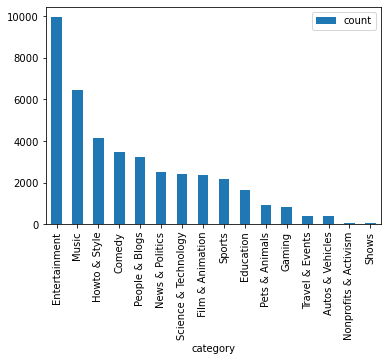

In [6]:
us_df.groupby('category').agg(count=('category', 'count')).sort_values(by='count', ascending=False).plot.bar()

In [7]:
us_df.head()

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,0mlNzVSJrT0,17.14.11,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,False,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs
2,STI2fI7sKMo,17.14.11,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,False,False,False,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs
3,KODzih-pYlU,17.14.11,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,2017-11-11 18:08:04+00:00,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062,7250,217,456,False,False,False,Molly is an god damn amazing human and she cha...,People & Blogs
4,8mhTWqWlQzU,17.14.11,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,2017-11-11 01:19:33+00:00,wearing online dollar store makeup for a week|...,2744430,115426,1110,6541,False,False,False,I found this online dollar store called ShopMi...,People & Blogs


In [8]:
us_df['like_pct'] = us_df['likes'] / us_df['views'] * 100
us_df['len_desc'] = us_df['description'].str.split().str.len()
us_df['len_title'] = us_df['title'].str.split().str.len()
us_df['qty_tags'] = us_df['tags'].str.split('|').str.len()

us_df.head()

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,category,like_pct,len_desc,len_title,qty_tags
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,7.686932,130.0,7,1
1,0mlNzVSJrT0,17.14.11,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,False,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs,2.511974,16.0,3,4
2,STI2fI7sKMo,17.14.11,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,False,False,False,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,1.386375,57.0,13,44
3,KODzih-pYlU,17.14.11,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,2017-11-11 18:08:04+00:00,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062,7250,217,456,False,False,False,Molly is an god damn amazing human and she cha...,People & Blogs,3.679045,78.0,10,12
4,8mhTWqWlQzU,17.14.11,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,2017-11-11 01:19:33+00:00,wearing online dollar store makeup for a week|...,2744430,115426,1110,6541,False,False,False,I found this online dollar store called ShopMi...,People & Blogs,4.205828,75.0,8,25


In [9]:
us_df['trending_date'] = pd.to_datetime(us_df['trending_date'], format='%y.%d.%m')
us_df['publish_date'] = pd.to_datetime(us_df['publish_time'].dt.date)
us_df['trending_delta'] = us_df['trending_date'] - us_df['publish_date']
us_df

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,...,ratings_disabled,video_error_or_removed,description,category,like_pct,len_desc,len_title,qty_tags,publish_date,trending_delta
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,...,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,7.686932,130.0,7,1,2017-11-13,1 days
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,...,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs,2.511974,16.0,3,4,2017-04-21,207 days
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,...,False,False,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,1.386375,57.0,13,44,2017-11-11,3 days
3,KODzih-pYlU,2017-11-14,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,2017-11-11 18:08:04+00:00,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062,7250,217,456,...,False,False,Molly is an god damn amazing human and she cha...,People & Blogs,3.679045,78.0,10,12,2017-11-11,3 days
4,8mhTWqWlQzU,2017-11-14,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,2017-11-11 01:19:33+00:00,wearing online dollar store makeup for a week|...,2744430,115426,1110,6541,...,False,False,I found this online dollar store called ShopMi...,People & Blogs,4.205828,75.0,8,25,2017-11-11,3 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,V6ElE2xs48c,2018-06-02,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,2018-05-10 21:01:22+00:00,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1324482,22413,608,1644,...,False,False,"On an island full of Van Gundys, Stan gets tal...",Shows,1.692209,36.0,10,33,2018-05-10,23 days
40945,V6ElE2xs48c,2018-06-03,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,2018-05-10 21:01:22+00:00,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1332252,22461,610,1648,...,False,False,"On an island full of Van Gundys, Stan gets tal...",Shows,1.685942,36.0,10,33,2018-05-10,24 days
40946,V6ElE2xs48c,2018-06-04,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,2018-05-10 21:01:22+00:00,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1340039,22504,615,1648,...,False,False,"On an island full of Van Gundys, Stan gets tal...",Shows,1.679354,36.0,10,33,2018-05-10,25 days
40947,V6ElE2xs48c,2018-06-05,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,2018-05-10 21:01:22+00:00,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1345086,22542,615,1649,...,False,False,"On an island full of Van Gundys, Stan gets tal...",Shows,1.675878,36.0,10,33,2018-05-10,26 days


In [15]:
from datetime import tzinfo, timedelta, datetime

<AxesSubplot:xlabel='len_desc', ylabel='like_pct'>

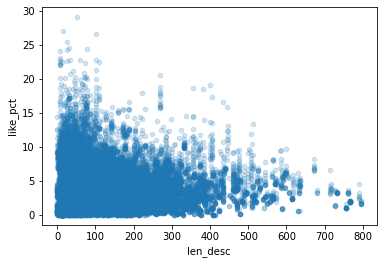

In [26]:
us_df.plot.scatter('len_desc', 'like_pct', alpha=0.2)

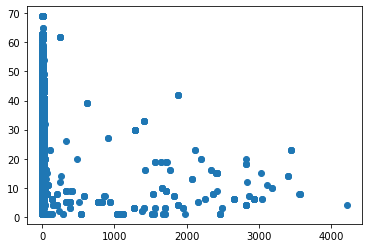

In [17]:
plt.scatter(us_df['trending_delta'].dt.days, us_df['qty_tags'])

In [18]:
us_df

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,...,ratings_disabled,video_error_or_removed,description,category,like_pct,len_desc,len_title,qty_tags,publish_date,trending_delta
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,...,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,7.686932,130.0,7,1,2017-11-13,1 days
1,0mlNzVSJrT0,2017-11-14,Me-O Cats Commercial,Nobrand,2017-04-21 06:47:32+00:00,"cute|""cats""|""thai""|""eggs""",98966,2486,184,532,...,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs,2.511974,16.0,3,4,2017-04-21,207 days
2,STI2fI7sKMo,2017-11-14,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,2017-11-11 15:00:03+00:00,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053,4451,1772,895,...,False,False,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs,1.386375,57.0,13,44,2017-11-11,3 days
3,KODzih-pYlU,2017-11-14,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,2017-11-11 18:08:04+00:00,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062,7250,217,456,...,False,False,Molly is an god damn amazing human and she cha...,People & Blogs,3.679045,78.0,10,12,2017-11-11,3 days
4,8mhTWqWlQzU,2017-11-14,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,2017-11-11 01:19:33+00:00,wearing online dollar store makeup for a week|...,2744430,115426,1110,6541,...,False,False,I found this online dollar store called ShopMi...,People & Blogs,4.205828,75.0,8,25,2017-11-11,3 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,V6ElE2xs48c,2018-06-02,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,2018-05-10 21:01:22+00:00,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1324482,22413,608,1644,...,False,False,"On an island full of Van Gundys, Stan gets tal...",Shows,1.692209,36.0,10,33,2018-05-10,23 days
40945,V6ElE2xs48c,2018-06-03,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,2018-05-10 21:01:22+00:00,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1332252,22461,610,1648,...,False,False,"On an island full of Van Gundys, Stan gets tal...",Shows,1.685942,36.0,10,33,2018-05-10,24 days
40946,V6ElE2xs48c,2018-06-04,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,2018-05-10 21:01:22+00:00,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1340039,22504,615,1648,...,False,False,"On an island full of Van Gundys, Stan gets tal...",Shows,1.679354,36.0,10,33,2018-05-10,25 days
40947,V6ElE2xs48c,2018-06-05,Game of Zones - S5:E5: The Isle of Van Gundy,Bleacher Report,2018-05-10 21:01:22+00:00,"bleacher report|""br""|""nba""|""Stan Van Gundy""|""J...",1345086,22542,615,1649,...,False,False,"On an island full of Van Gundys, Stan gets tal...",Shows,1.675878,36.0,10,33,2018-05-10,26 days


In [33]:
us_df['channel_title'].value_counts()

ESPN                                      203
The Tonight Show Starring Jimmy Fallon    197
Vox                                       193
Netflix                                   193
TheEllenShow                              193
                                         ... 
American Bridge 21st Century                1
CityNews Toronto                            1
Steve Kovach                                1
LetsGoWarriors                              1
Aerie                                       1
Name: channel_title, Length: 2207, dtype: int64

<AxesSubplot:xlabel='trending_delta', ylabel='qty_tags'>

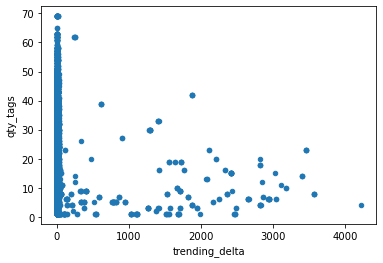

In [19]:
tmp = pd.DataFrame(us_df['trending_delta'].dt.days).join(us_df['qty_tags'])
tmp.plot.scatter('trending_delta', 'qty_tags')

Text(0.5, 1.0, '')

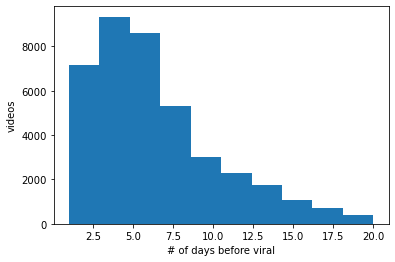

In [20]:
plt.hist(us_df['trending_delta'].dt.days, range=(1, 20))
plt.xlabel('# of days before viral')
plt.ylabel('videos')
plt.title('')

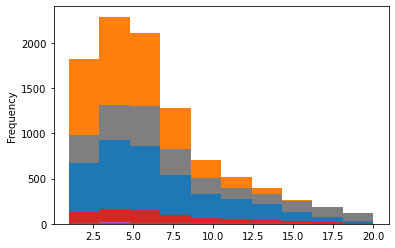

In [21]:
for c in list(us_df['category'].unique()):
    us_df[us_df['category'] == c]['trending_delta'].dt.days.plot.hist(range=(1, 20))

Text(0, 0.5, 'count')

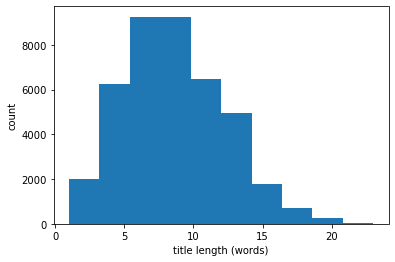

In [27]:
plt.hist(us_df['len_title'], bins=10, )
plt.xlabel('title length (words)')
plt.ylabel('count')